# Azure AI Agent service - Code interpreter

<img src="https://learn.microsoft.com/en-us/azure/ai-services/agents/media/agent-service-the-glue.png" width=800>

> https://learn.microsoft.com/en-us/azure/ai-services/agents/

In [1]:
#%pip install ipyplot
#%pip install matplotlib

## Load all dependencies

In [2]:
import glob
import json
import ipyplot
import matplotlib.pyplot as plt
import os
import sys
import time

from azure.ai.agents import AgentsClient 
from azure.identity import DefaultAzureCredential
from azure.ai.agents.models import CodeInterpreterTool, FilePurpose, ListSortOrder
from dotenv import load_dotenv
from openai import AzureOpenAI
from PIL import Image
from pathlib import Path

In [3]:
load_dotenv()

True

## Connect to AI Foundry Project 

In [4]:
endpoint = os.getenv("PROJECT_ENDPOINT")
print(f"Using endpoint: {endpoint}")
credential = DefaultAzureCredential()

project_client = AgentsClient(endpoint=endpoint, credential=credential)

Using endpoint: https://aq-ai-foundry-sweden-central.services.ai.azure.com/api/projects/firstProject


## Get example file

In [5]:
DATA_DIR = "data"

os.makedirs(DATA_DIR, exist_ok=True)

output_file = os.path.join(DATA_DIR, "titanic.csv")

In [6]:
!wget https://raw.githubusercontent.com/datasciencedojo/datasets/refs/heads/master/titanic.csv -O $output_file

--2025-06-17 11:17:08--  https://raw.githubusercontent.com/datasciencedojo/datasets/refs/heads/master/titanic.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60302 (59K) [text/plain]
Saving to: ‘data/titanic.csv’

data/titanic.csv    100%[===================>]  58.89K  --.-KB/s    in 0.01s   

2025-06-17 11:17:08 (4.76 MB/s) - ‘data/titanic.csv’ saved [60302/60302]



In [7]:
model = "gpt-4o-mini"

## Upload file to agent

In [8]:
file = project_client.files.upload_and_poll(file_path=output_file,
                                                  purpose=FilePurpose.AGENTS)

print(f"Uploaded file, file ID: {file.id}")

Uploaded file, file ID: assistant-45ASv7ZMpUZSt16768GT1Q


## Create and agent with code interpreter tool

In [9]:
code_interpreter = CodeInterpreterTool(file_ids=[file.id])

# Create agent with code interpreter tool and tools_resources
agent = project_client.create_agent(
    model=os.environ["MODEL_DEPLOYMENT_NAME"],
    name="my-agent",
    instructions="You are helpful agent",
    tools=code_interpreter.definitions,
    tool_resources=code_interpreter.resources,
)
print(f"Created agent, agent ID: {agent.id} File ID: {file.id}")

Created agent, agent ID: asst_Sfo7xnvStX63cPufGl847SKt File ID: assistant-45ASv7ZMpUZSt16768GT1Q


## Create a thread for the agent to run

In [10]:
# create a thread
thread = project_client.threads.create()
print(f"Created thread, thread ID: {thread.id}")

prompt = "Plot a correlation matrix using the blues theme"

# create a message
message = project_client.messages.create(
    thread_id=thread.id,
    role="user",
    content=prompt,
)
print(f"Created message, message ID: {message.id}")

messages = project_client.messages.list(thread_id=thread.id)
print(f"Messages: {messages}")

Created thread, thread ID: thread_jBsSVPfa4yhm98TNp1qXM4Tf
Created message, message ID: msg_aq3yBb6oQCZLwx4V8Kcp8B9m
Messages: <iterator object azure.core.paging.ItemPaged at 0x11e5f2120>


## Run the code interpreter agent

In [11]:
# create a run for the agent
run = project_client.runs.create_and_process(thread_id=thread.id,
                                                   agent_id=agent.id)
print(f"Created run, run ID: {run.id}")

Created run, run ID: run_QiBNuHjviCc4a42TsC04DeeJ


## Get the messages generated by the run

In [12]:
messages = project_client.messages.list(thread_id=thread.id)
print(f"Messages: {messages}")

# Fetch and log all messages
messages = project_client.messages.list(thread_id=thread.id, order=ListSortOrder.ASCENDING)

# Print last messages from the thread
for msg in messages:
    if msg.text_messages:
        last_text = msg.text_messages[-1]
        print(f"{msg.role}: {last_text.text.value}")

Messages: <iterator object azure.core.paging.ItemPaged at 0x11e5bec10>
MessageRole.USER: Plot a correlation matrix using the blues theme
MessageRole.AGENT: Let's start by loading your file and examining its contents. Then, I'll compute the correlation matrix and plot it using a blue color theme.
MessageRole.AGENT: Your file contains Titanic dataset-like information. I'll calculate the correlation matrix for the numeric columns and plot it using a blues color theme.
MessageRole.AGENT: Here is the correlation matrix for the numeric columns in your dataset, visualized with the blues color theme. If you have any specific analysis or would like to plot other features, please let me know!


## Save image(s) generated by the run

In [13]:
IMAGES_DIR = "images"

images_list = []

# [START get_messages_and_save_files]
messages = project_client.messages.list(thread_id=thread.id)
print(f"Messages: {messages}")

for msg in messages:
        # Save every image file in the message
        for img in msg.image_contents:
            file_id = img.image_file.file_id
            file_name = f"./images/{file_id}_image_file.png"
            project_client.files.save(file_id=file_id, file_name=file_name)
            print(f"Saved image file to: {Path.cwd() / file_name}")

        # Print details of every file-path annotation
        for ann in msg.file_path_annotations:
            print("File Paths:")
            print(f"  Type: {ann.type}")
            print(f"  Text: {ann.text}")
            print(f"  File ID: {ann.file_path.file_id}")
            print(f"  Start Index: {ann.start_index}")
            print(f"  End Index: {ann.end_index}")
        # [END get_messages_and_save_files]
        # Print last messages from the thread
        for msg in messages:
            if msg.text_messages:
                last_text = msg.text_messages[-1]
                print(f"{msg.role}: {last_text.text.value}")


Messages: <iterator object azure.core.paging.ItemPaged at 0x11e5f95b0>
Saved image file to: /Users/arturoquiroga/GITHUB/AZURE AI AGENT SERVICE/1_Azure Agent Service/NOTEBOOKS/images/assistant-Uonyn5PVA2gcSh2BbBdQsw_image_file.png
MessageRole.AGENT: Your file contains Titanic dataset-like information. I'll calculate the correlation matrix for the numeric columns and plot it using a blues color theme.
MessageRole.AGENT: Let's start by loading your file and examining its contents. Then, I'll compute the correlation matrix and plot it using a blue color theme.
MessageRole.USER: Plot a correlation matrix using the blues theme


## Display image

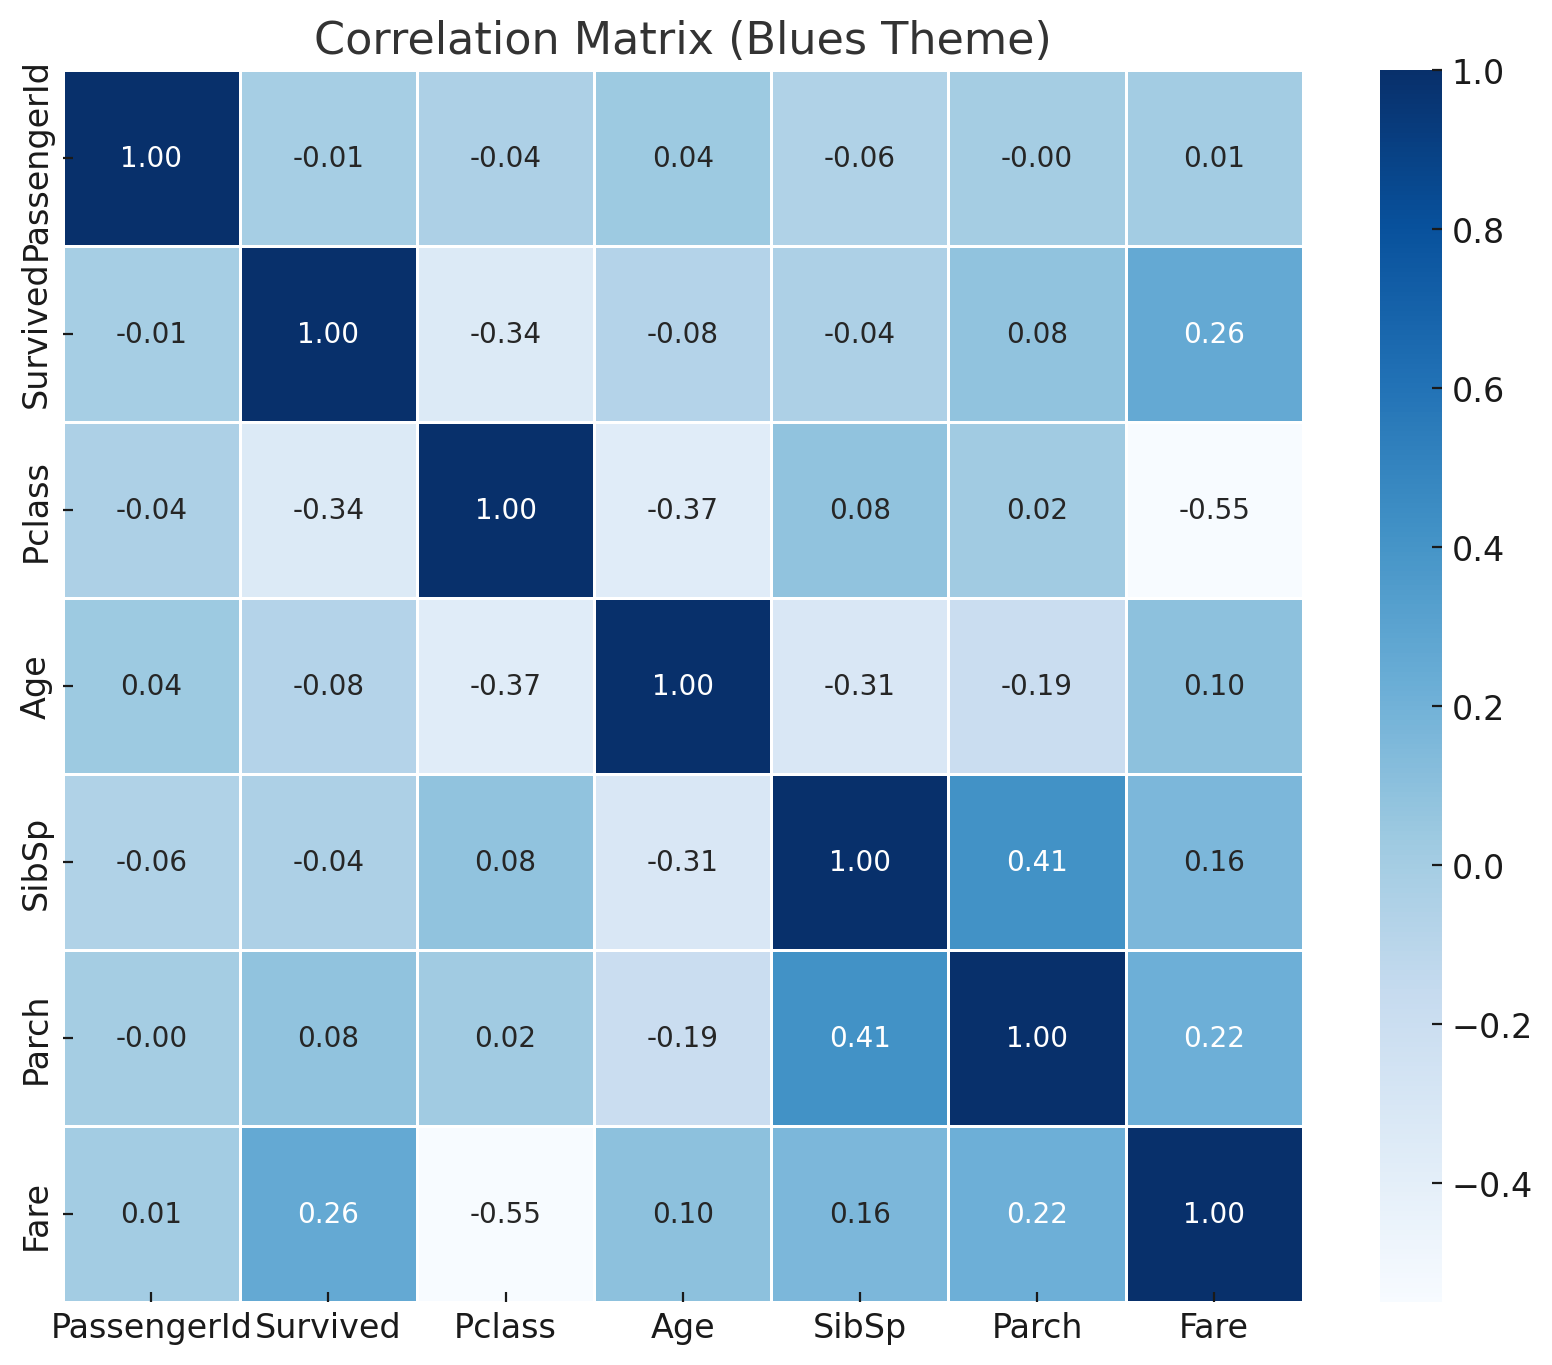

In [14]:
from IPython.display import Image, display
from pathlib import Path

file_id = img.image_file.file_id
file_name = f"./{file_id}_image_file.png"
file_path = Path.cwd() / file_name
display(Image(filename=str(file_path)))


## Example

In [15]:
# create a thread
thread = project_client.threads.create()
print(f"Created thread, thread ID: {thread.id}")

prompt = "Generate a bivariate analysis of survival and pclass. Use some greens colors."

# create a message
message = project_client.messages.create(
    thread_id=thread.id,
    role="user",
    content=prompt,
)
print(f"Created message, message ID: {message.id}")

Created thread, thread ID: thread_SnPKMi0dHFWbcSjFjV8DoC97
Created message, message ID: msg_PryeIWlQOcTuduB8aUgqO3wq


In [16]:
# create a run for the agent
run = project_client.runs.create_and_process(thread_id=thread.id,
                                                   agent_id=agent.id)
print(f"Created run, run ID: {run.id}")

Created run, run ID: run_FdCnnJttOFoXJZIWRdVFDCGa


In [17]:
run.usage

{'prompt_tokens': 3020, 'completion_tokens': 434, 'total_tokens': 3454, 'prompt_token_details': {'cached_tokens': 0}}

In [18]:
    IMAGES_DIR = "images"

    images_list = []

    # [START get_messages_and_save_files]
    messages = project_client.messages.list(thread_id=thread.id)
    print(f"Messages: {messages}")

    for msg in messages:
        # Save every image file in the message
        for img in msg.image_contents:
            file_id = img.image_file.file_id
            file_name = f"{file_id}_image_file.png"
            project_client.files.save(file_id=file_id, file_name=file_name)
            print(f"Saved image file to: {Path.cwd() / file_name}")

        # Print details of every file-path annotation
        for ann in msg.file_path_annotations:
            print("File Paths:")
            print(f"  Type: {ann.type}")
            print(f"  Text: {ann.text}")
            print(f"  File ID: {ann.file_path.file_id}")
            print(f"  Start Index: {ann.start_index}")
            print(f"  End Index: {ann.end_index}")
        # [END get_messages_and_save_files]
        # Print last messages from the thread
        for msg in messages:
            if msg.text_messages:
                last_text = msg.text_messages[-1]
                print(f"{msg.role}: {last_text.text.value}")

Messages: <iterator object azure.core.paging.ItemPaged at 0x11e5f96e0>
Saved image file to: /Users/arturoquiroga/GITHUB/AZURE AI AGENT SERVICE/1_Azure Agent Service/NOTEBOOKS/assistant-7CVkAXTMb4eXjW1Daqk3bu_image_file.png
MessageRole.AGENT: The relevant columns in your dataset are:
- `Survived`: Whether the passenger survived (1) or not (0)
- `Pclass`: Passenger class (1st, 2nd, 3rd)

Now, I will create a bivariate plot showing survival counts by class using a green color palette.
MessageRole.AGENT: Let's perform a bivariate analysis between the "Survived" and "Pclass" variables in your dataset with a focus on green color palettes for clearer visualization.

I will:
1. Load and preview the dataset.
2. Check the relevant columns.
3. Generate a count plot or crosstab visualization showing survival rates per class.

Let me start by loading and previewing the data.
MessageRole.USER: Generate a bivariate analysis of survival and pclass. Use some greens colors.


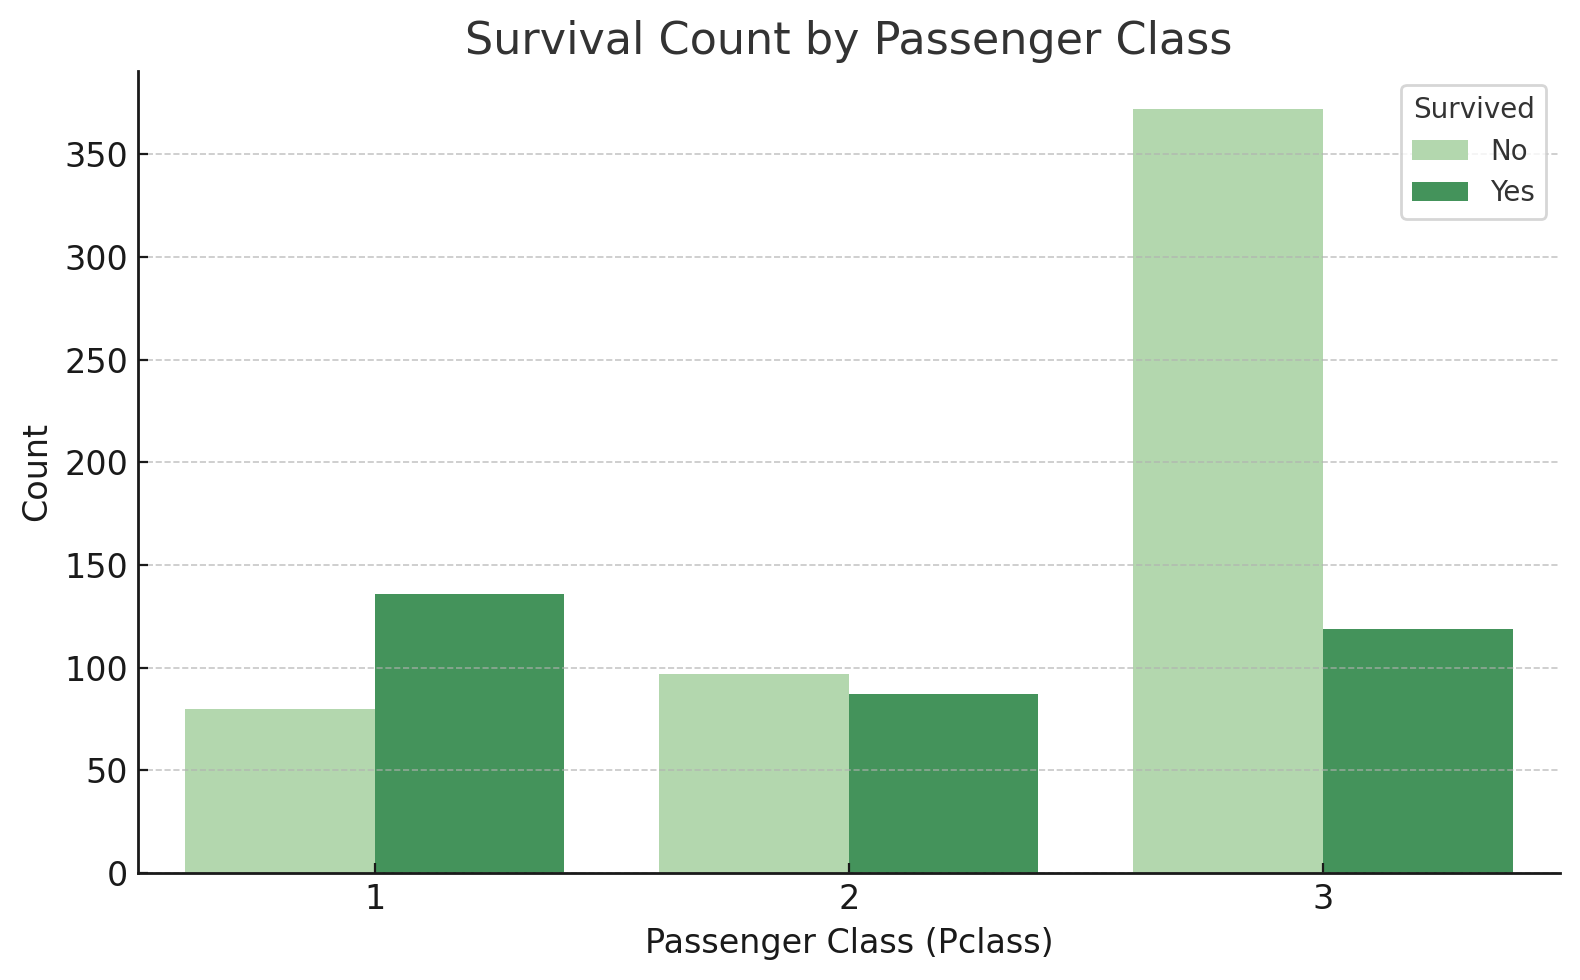

In [19]:
from IPython.display import Image, display
from pathlib import Path

file_id = img.image_file.file_id
file_name = f"./{file_id}_image_file.png"
file_path = Path.cwd() / file_name
display(Image(filename=str(file_path)))

## Example

In [20]:
# create a thread
thread = project_client.threads.create()
print(f"Created thread, thread ID: {thread.id}")

prompt = "Generate a violin plot of Pclass by Age and Gender. Use lime and cyan colors."

# create a message
message = project_client.messages.create(
    thread_id=thread.id,
    role="user",
    content=prompt,
)
print(f"Created message, message ID: {message.id}")

Created thread, thread ID: thread_BtbjRsNwDe5I1SYThiGicH2n
Created message, message ID: msg_iZlTzvp4QdqoX7MYwOb8UTqX


In [21]:
# create a run for the agent
run = project_client.runs.create_and_process(thread_id=thread.id,
                                                   agent_id=agent.id)
print(f"Created run, run ID: {run.id}")

run.usage

Created run, run ID: run_vV3GLlA30fXFF7XoedQnmocf


{'prompt_tokens': 2539, 'completion_tokens': 346, 'total_tokens': 2885, 'prompt_token_details': {'cached_tokens': 0}}

In [22]:
    IMAGES_DIR = "images"

    images_list = []

    # [START get_messages_and_save_files]
    messages = project_client.messages.list(thread_id=thread.id)
    print(f"Messages: {messages}")

    for msg in messages:
        # Save every image file in the message
        for img in msg.image_contents:
            file_id = img.image_file.file_id
            file_name = f"{file_id}_image_file.png"
            project_client.files.save(file_id=file_id, file_name=file_name)
            print(f"Saved image file to: {Path.cwd() / file_name}")

        # Print details of every file-path annotation
        for ann in msg.file_path_annotations:
            print("File Paths:")
            print(f"  Type: {ann.type}")
            print(f"  Text: {ann.text}")
            print(f"  File ID: {ann.file_path.file_id}")
            print(f"  Start Index: {ann.start_index}")
            print(f"  End Index: {ann.end_index}")
        # [END get_messages_and_save_files]
        # Print last messages from the thread
        for msg in messages:
            if msg.text_messages:
                last_text = msg.text_messages[-1]
                print(f"{msg.role}: {last_text.text.value}")

Messages: <iterator object azure.core.paging.ItemPaged at 0x11e70c5f0>
Saved image file to: /Users/arturoquiroga/GITHUB/AZURE AI AGENT SERVICE/1_Azure Agent Service/NOTEBOOKS/assistant-Uy1Zyr38UJhrqdraLd3yyJ_image_file.png
MessageRole.AGENT: The dataset appears to be a version of the Titanic dataset, with columns `Pclass`, `Age`, and `Sex` (gender) available.

Next, I'll create a violin plot with:
- X-axis: `Pclass`
- Y-axis: `Age`
- Hue: `Sex` (Gender)
- Colors: lime and cyan

I will use seaborn and matplotlib for this plot. Let's proceed!
MessageRole.AGENT: Let's start by loading your data and examining its structure so I can generate the requested violin plot.
MessageRole.USER: Generate a violin plot of Pclass by Age and Gender. Use lime and cyan colors.


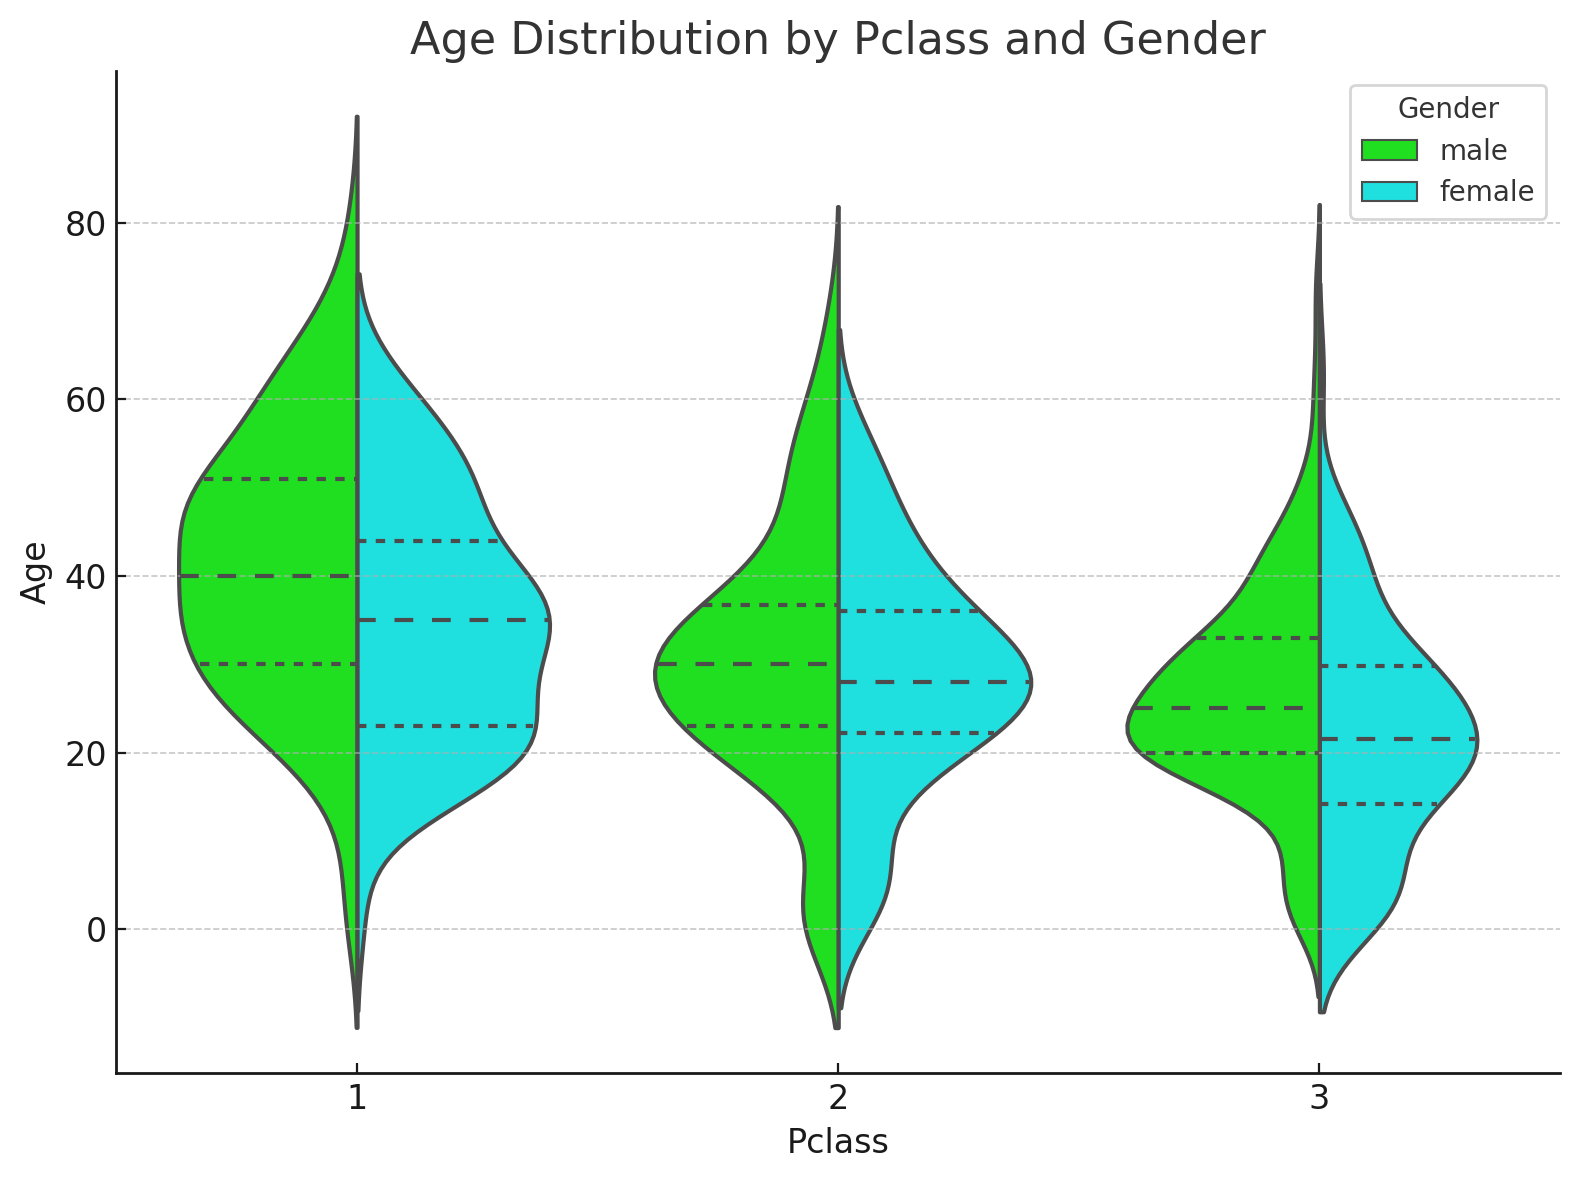

In [23]:
from IPython.display import Image, display
from pathlib import Path

file_id = img.image_file.file_id
file_name = f"./{file_id}_image_file.png"
file_path = Path.cwd() / file_name
display(Image(filename=str(file_path)))

## Example

In [24]:
# create a thread
thread = project_client.threads.create()
print(f"Created thread, thread ID: {thread.id}")

prompt = "Generate the age distribution. Use lightblue color"

# create a message
message = project_client.messages.create(
    thread_id=thread.id,
    role="user",
    content=prompt,
)
print(f"Created message, message ID: {message.id}")

Created thread, thread ID: thread_KMLhps7guGZBLBqJG6rCXoqI
Created message, message ID: msg_VKsLvMKXeJz6qBxOEVBB3Ex4


In [25]:
# create a run for the agent
run = project_client.runs.create_and_process(thread_id=thread.id,
                                                   agent_id=agent.id)
print(f"Created run, run ID: {run.id}")

run.usage

Created run, run ID: run_FyA2AzCxbKLJwJHGb4gqPHDn


{'prompt_tokens': 2605, 'completion_tokens': 240, 'total_tokens': 2845, 'prompt_token_details': {'cached_tokens': 0}}

In [26]:
    IMAGES_DIR = "images"

    images_list = []

    # [START get_messages_and_save_files]
    messages = project_client.messages.list(thread_id=thread.id)
    print(f"Messages: {messages}")

    for msg in messages:
        # Save every image file in the message
        for img in msg.image_contents:
            file_id = img.image_file.file_id
            file_name = f"{file_id}_image_file.png"
            project_client.files.save(file_id=file_id, file_name=file_name)
            print(f"Saved image file to: {Path.cwd() / file_name}")

        # Print details of every file-path annotation
        for ann in msg.file_path_annotations:
            print("File Paths:")
            print(f"  Type: {ann.type}")
            print(f"  Text: {ann.text}")
            print(f"  File ID: {ann.file_path.file_id}")
            print(f"  Start Index: {ann.start_index}")
            print(f"  End Index: {ann.end_index}")
        # [END get_messages_and_save_files]
        # Print last messages from the thread
        for msg in messages:
            if msg.text_messages:
                last_text = msg.text_messages[-1]
                print(f"{msg.role}: {last_text.text.value}")

Messages: <iterator object azure.core.paging.ItemPaged at 0x11e533bd0>
Saved image file to: /Users/arturoquiroga/GITHUB/AZURE AI AGENT SERVICE/1_Azure Agent Service/NOTEBOOKS/assistant-9a2dHzq9Ry9UEBBUUiwVLC_image_file.png
MessageRole.AGENT: Your data includes an `Age` column, so I will now generate an age distribution plot using a light blue color.
MessageRole.AGENT: I’ll generate an age distribution plot using the data you provided. First, I need to take a look at the file contents to identify the age column.
MessageRole.USER: Generate the age distribution. Use lightblue color


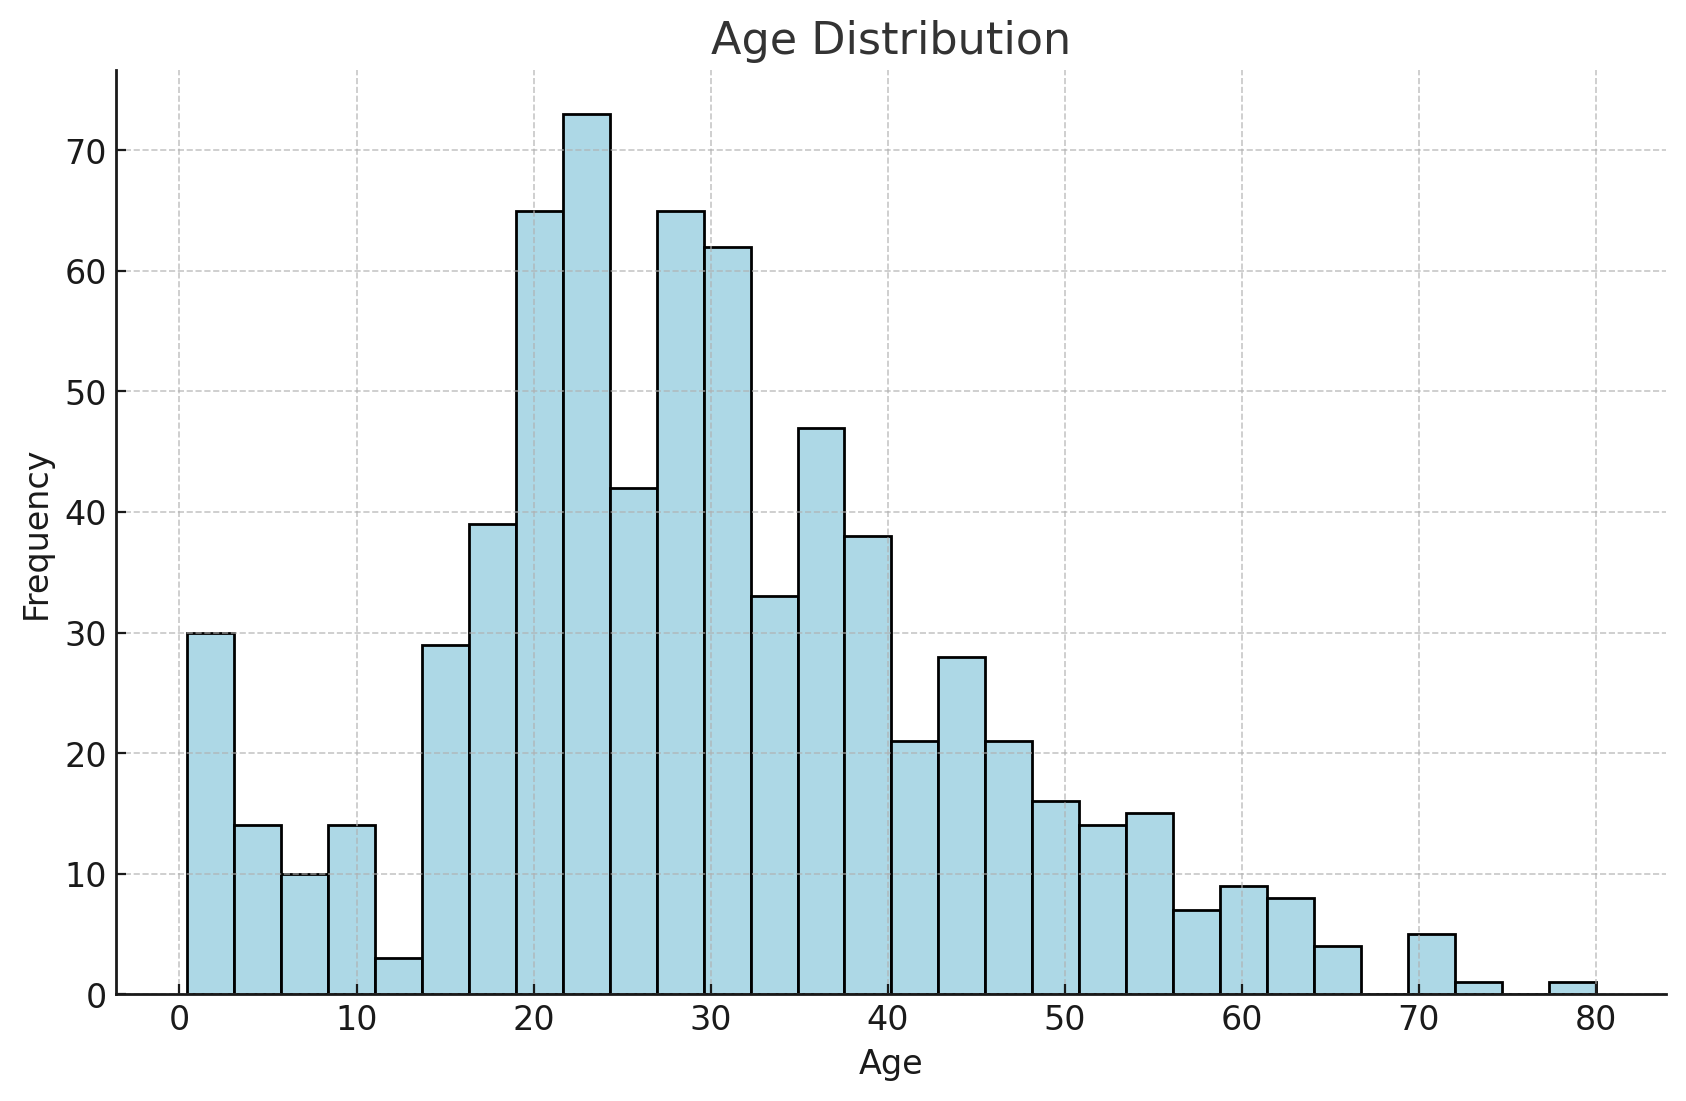

In [27]:
from IPython.display import Image, display
from pathlib import Path

file_id = img.image_file.file_id
file_name = f"./{file_id}_image_file.png"
file_path = Path.cwd() / file_name
display(Image(filename=str(file_path)))

## All images

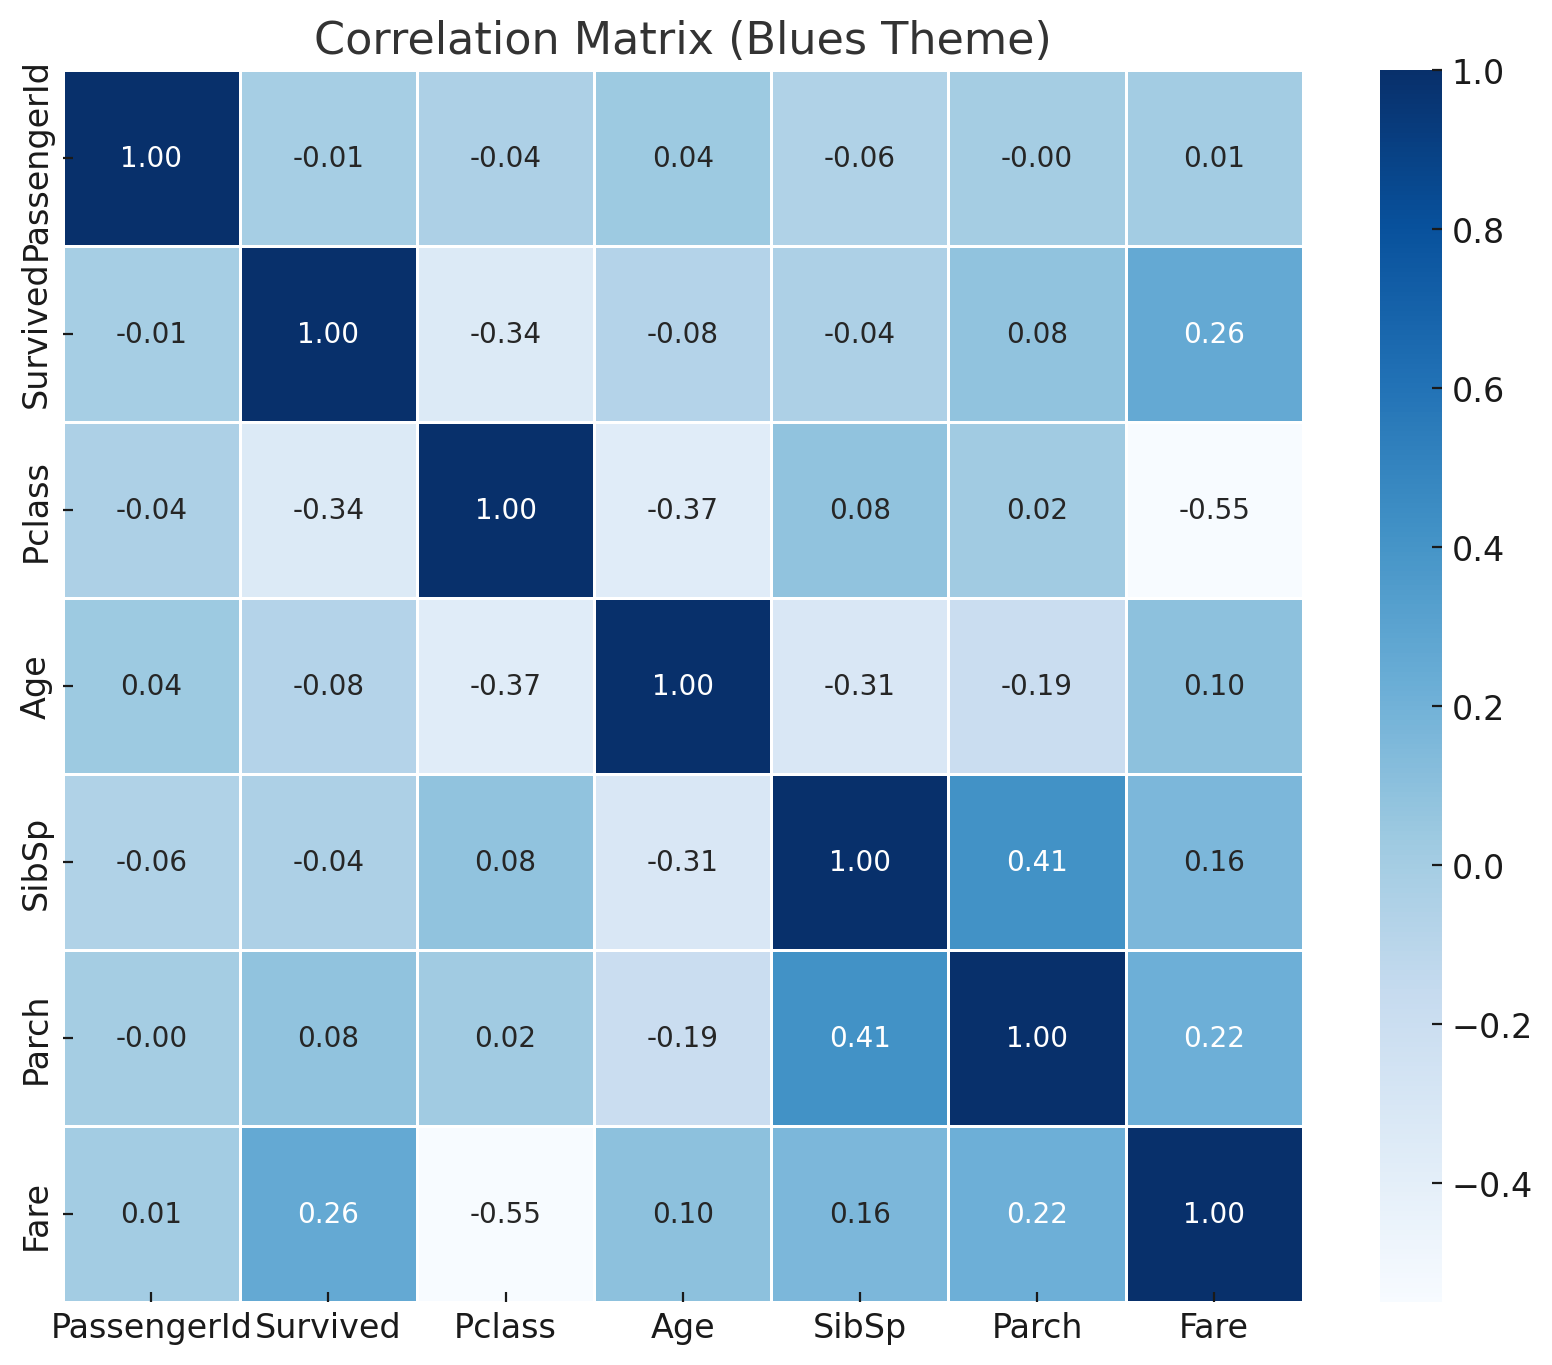

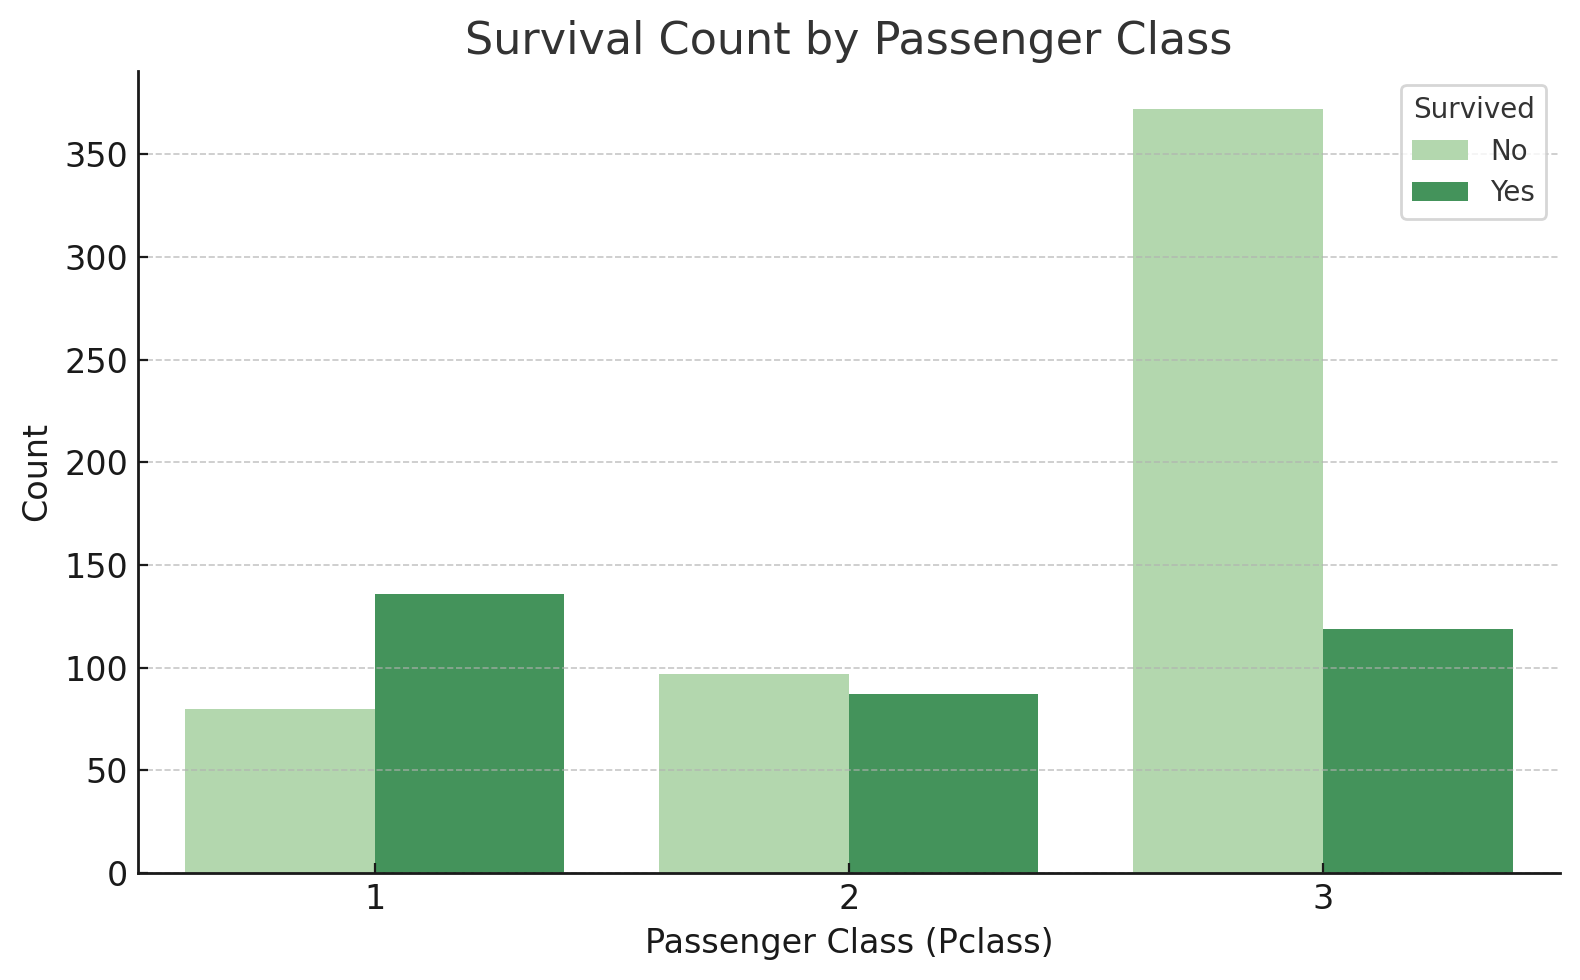

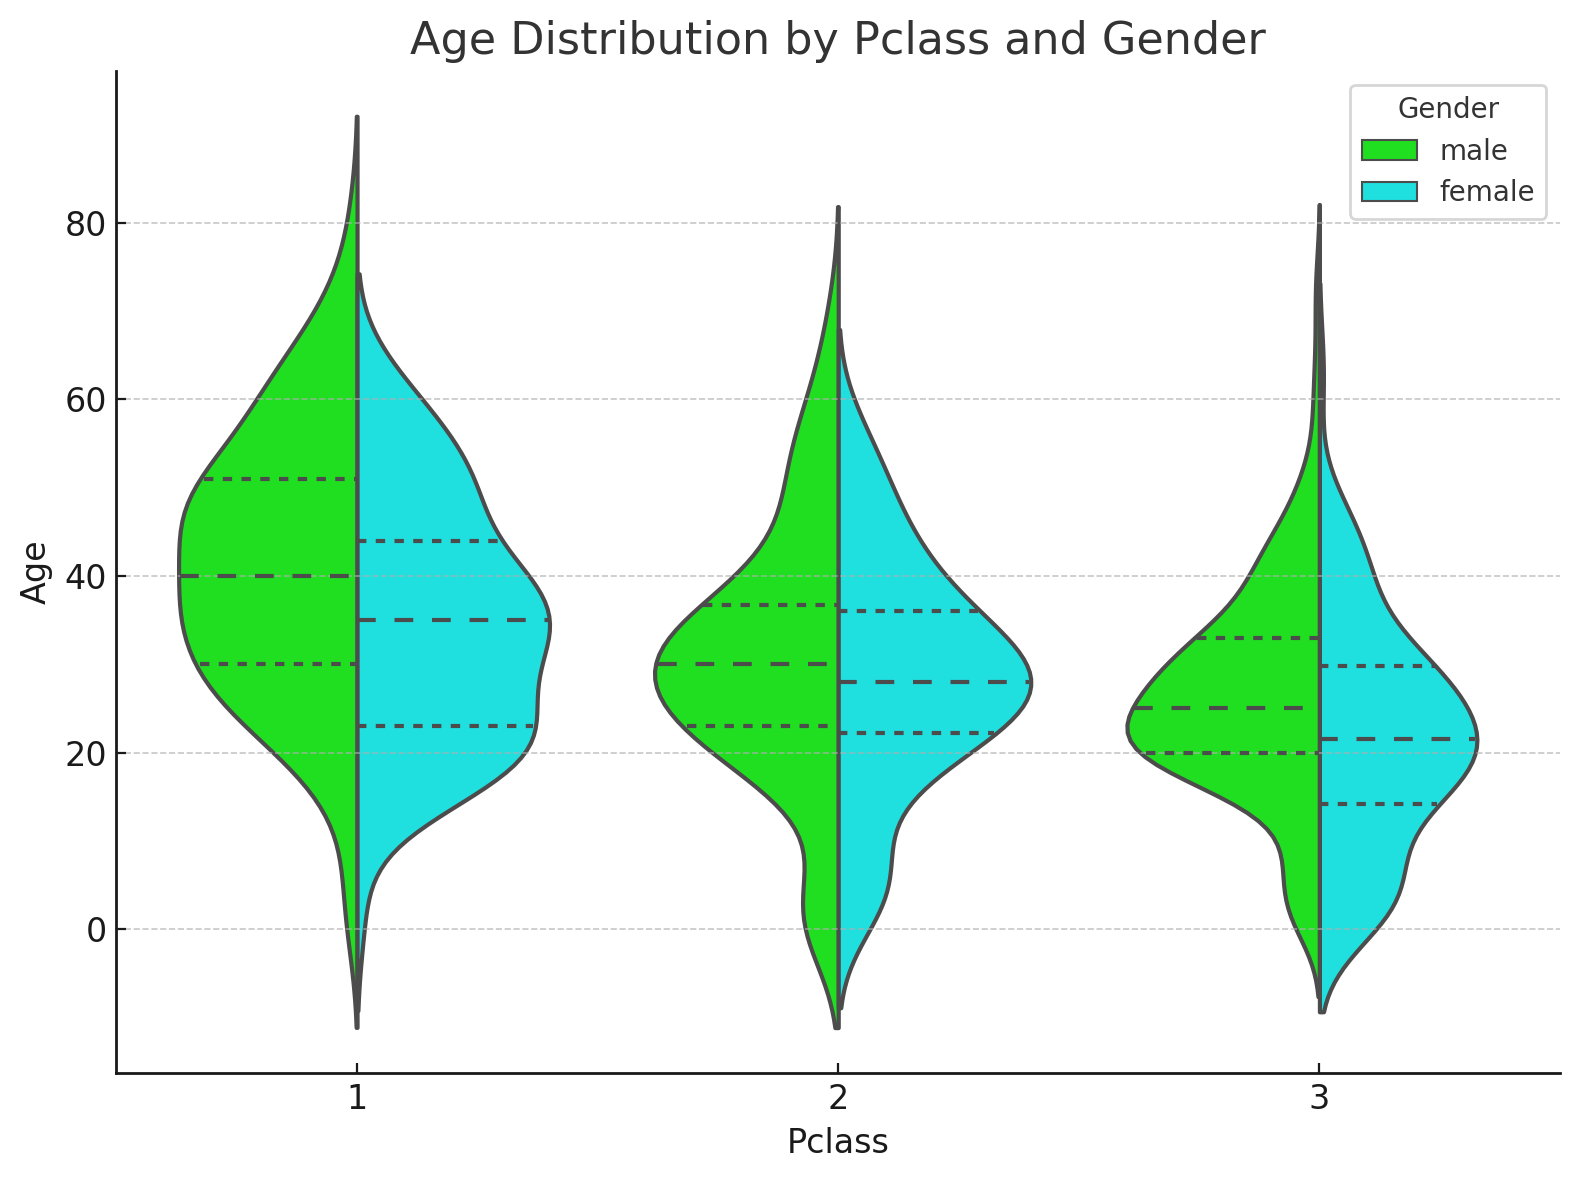

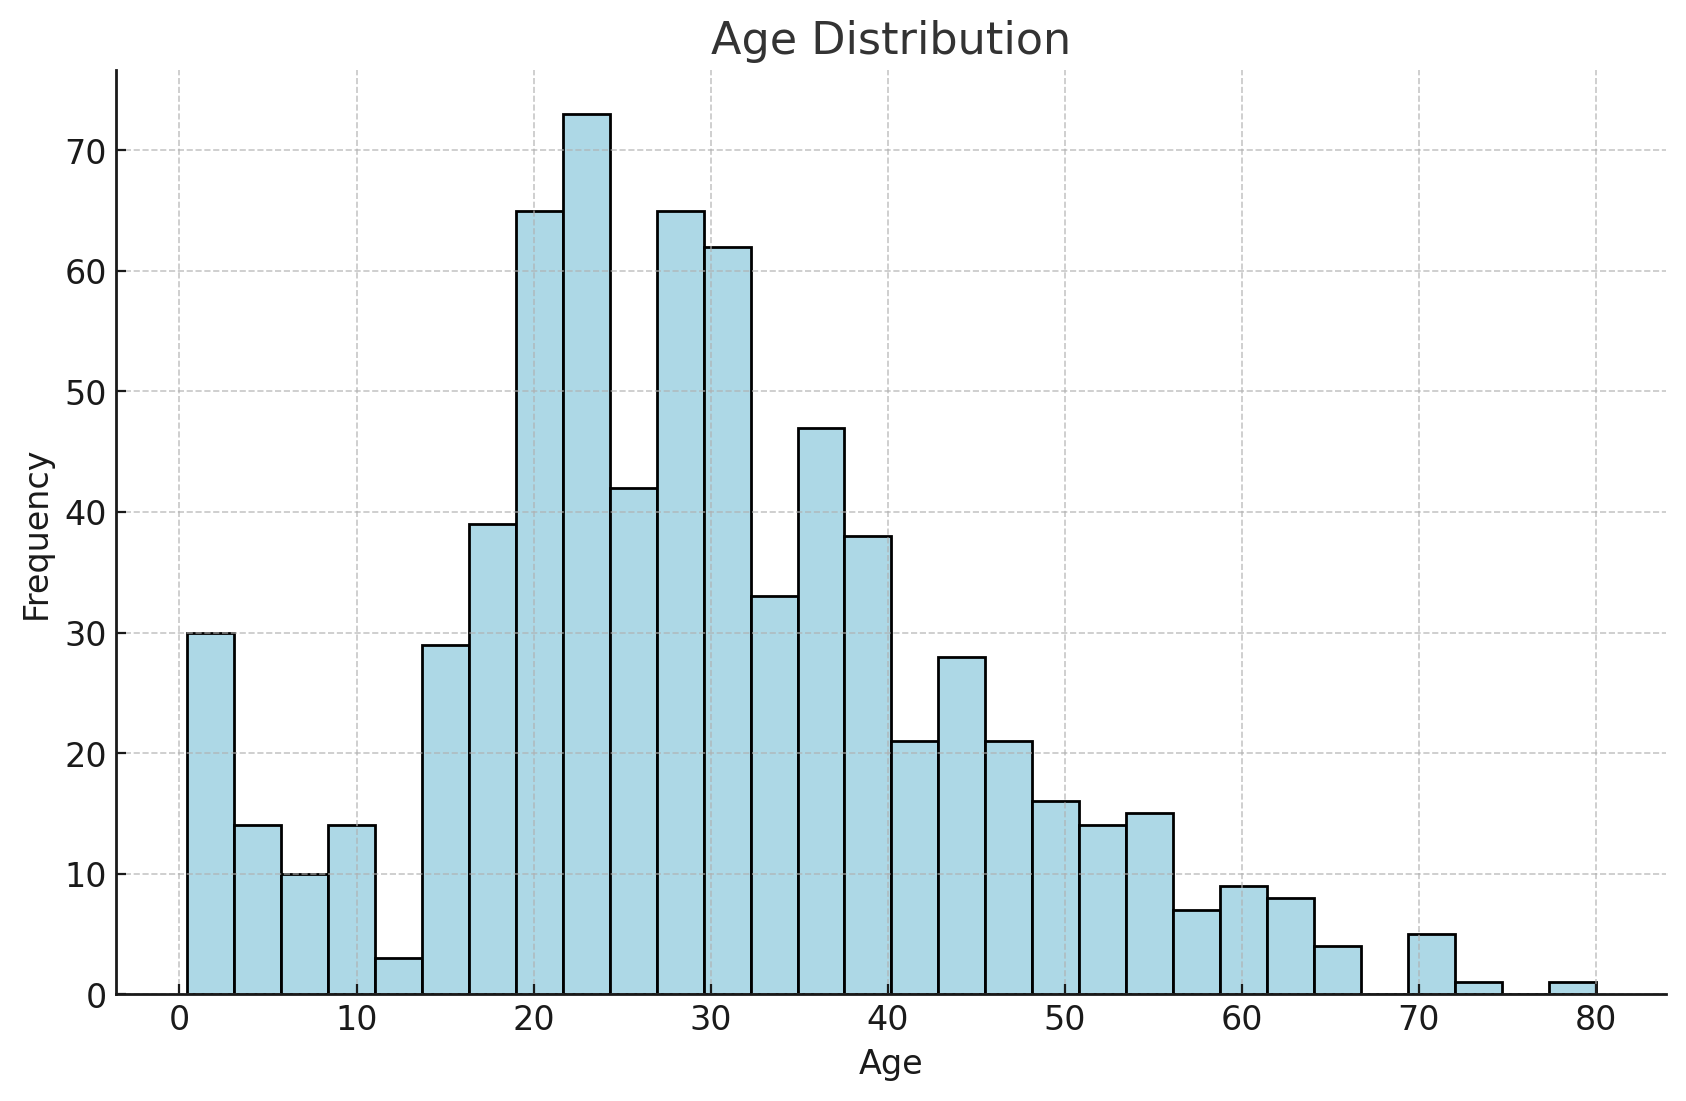

In [28]:
from IPython.display import display, Image
from pathlib import Path

# Define the directory to search for images (current working directory)
image_dir = Path.cwd()

# Find all files matching the pattern 'assistant-*.png'
image_files = sorted(
    [f for f in image_dir.glob('assistant-*.png')],
    key=lambda x: x.stat().st_mtime
)

if image_files:
    for img_path in image_files:
        display(Image(filename=str(img_path)))
else:
    print('No assistant-*.png files found in the current directory.')

## Cleaning

In [29]:
project_client.delete_agent(agent.id)
print(f"Deleted agent, agent ID: {agent.id}")

Deleted agent, agent ID: asst_Sfo7xnvStX63cPufGl847SKt
